# Prepare your google colab PySpark Session (Step 1)

In [2]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install Spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the Spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your Spark folder to your system path environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Step 2-13

In [3]:
# 2. Read BostonHousing.csv dataset in PySpark
from google.colab import files
files.upload()
dataset = spark.read.csv('BostonHousing.csv',inferSchema=True, header =True)

Saving BostonHousing.csv to BostonHousing.csv


In [4]:
# 3. Combine features to a single vector columns using VectorAssembler (all columns other than target column medv
from pyspark.ml.feature import VectorAssembler

# Select the feature columns
features = [col for col in dataset.columns if col != 'medv']

# Create the VectorAssembler with feature columns
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Transform the dataset
data = assembler.transform(dataset).select("features","medv")

data.show(5)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
+--------------------+----+
only showing top 5 rows



In [5]:
# 4. Standardize features for principal component analysis
from pyspark.ml.feature import StandardScaler

# Create a StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withMean=True, withStd=True)

# Fit the scaler to the data
standardize = scaler.fit(data)

standardize_data = standardize.transform(data).select("scaledFeatures","medv")

standardize_data.show(5)


+--------------------+----+
|      scaledFeatures|medv|
+--------------------+----+
|[-0.4193669292132...|24.0|
|[-0.4169266699640...|21.6|
|[-0.4169289951277...|34.7|
|[-0.4163384035610...|33.4|
|[-0.4120740534296...|36.2|
+--------------------+----+
only showing top 5 rows



In [10]:
# 5. Train model for two principal component analysis
from pyspark.ml.feature import PCA

# Initialize PCA and set the number of components
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")

# Fit PCA model
model = pca.fit(standardize_data)

# Transform the data
pca_result = model.transform(standardize_data)

# Show the result
pca_result.select("pcaFeatures").show(5,truncate=False)

+------------------------------------------+
|pcaFeatures                               |
+------------------------------------------+
|[2.0962230302385834,0.7723484263420729]   |
|[1.4558109894474214,0.591399951826482]    |
|[2.072546551948186,0.5990465781004485]    |
|[2.6089217588643496,-0.006863826297572748]|
|[2.455754771931078,0.09761534604617135]   |
+------------------------------------------+
only showing top 5 rows



In [20]:
# 6. Collect distributed data in numpy array and then convert to pandas dataframe
import numpy as np

# Collect the PCA result as a list of rows
pcaFeatures = pca_result.select("pcaFeatures").collect()

# Convert to NumPy array
array = np.array([row['pcaFeatures'].toArray() for row in pcaFeatures])
print(array)

import pandas as pd

# Create a Pandas DataFrame
df_pd = pd.DataFrame(array, columns=["PC1", "PC2"])
print(df_pd.head())

[[2.09622303 0.77234843]
 [1.45581099 0.59139995]
 [2.07254655 0.59904658]
 ...
 [0.31205166 1.15410433]
 [0.27025162 1.04033206]
 [0.12567884 0.76122473]]
        PC1       PC2
0  2.096223  0.772348
1  1.455811  0.591400
2  2.072547  0.599047
3  2.608922 -0.006864
4  2.455755  0.097615


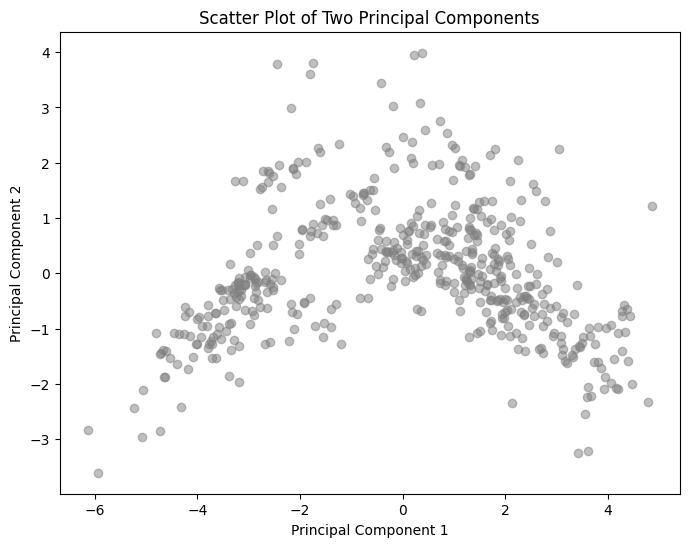

In [21]:
# 7. Plot two principal components
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_pd['PC1'], df_pd['PC2'], alpha=0.5, color='grey')
plt.title('Scatter Plot of Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [29]:
# 8. Vectorize features and target together for model development
standardize_data = standardize.transform(data).select("scaledFeatures","medv")

standardize_data.show(5)

+--------------------+----+
|      scaledFeatures|medv|
+--------------------+----+
|[-0.4193669292132...|24.0|
|[-0.4169266699640...|21.6|
|[-0.4169289951277...|34.7|
|[-0.4163384035610...|33.4|
|[-0.4120740534296...|36.2|
+--------------------+----+
only showing top 5 rows



In [30]:
# 9. Split dataset into training and testing dataset
train, test = standardize_data.randomSplit([0.7, 0.3], seed=100)

In [33]:
# 10. Fit model for linear regression
from pyspark.ml.regression import LinearRegression

# Linear Regression model
lr = LinearRegression(featuresCol='scaledFeatures', labelCol='medv')

# Fit the model on the training data
lr_model = lr.fit(train)

In [34]:
# 11. Find out model coefficients and intercept
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.6071222361003117,0.5711743584306606,-0.2892031115245631,0.5811066648203217,-1.4317495292943414,3.415484862028539,-0.6678879906969063,-3.139375010120938,2.608903031785101,-2.0082226947161637,-2.204245691247727,1.182569828827797,-3.0987034683253016]
Intercept: 22.672414563107363


In [42]:
# 12. Evaluate model for test dataset
from pyspark.ml.evaluation import RegressionEvaluator

# Predictions on the test data
predictions = lr_model.transform(test)

# Evaluator with RMSE metric
evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")

# RMSE
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE)= %g" % rmse)

# R2
r2 = evaluator.setMetricName("r2").evaluate(predictions)
print("R2 = %g" % r2)

print("The Root Mean Squared Error (RMSE) is 4.69355, which means the average error in the model’s \npredictions is about 4.7 units. The R² value is 0.695879, showing that my model explains around 69.59% of \nthe variance in the data.This is a overall good result, suggesting the model fits the data well")


Root Mean Squared Error (RMSE)= 4.69355
R2 = 0.695879
The Root Mean Squared Error (RMSE) is 4.69355, which means the average error in the model’s 
predictions is about 4.7 units. The R² value is 0.695879, showing that my model explains around 69.59% of 
the variance in the data.This is a overall good result, suggesting the model fits the data well


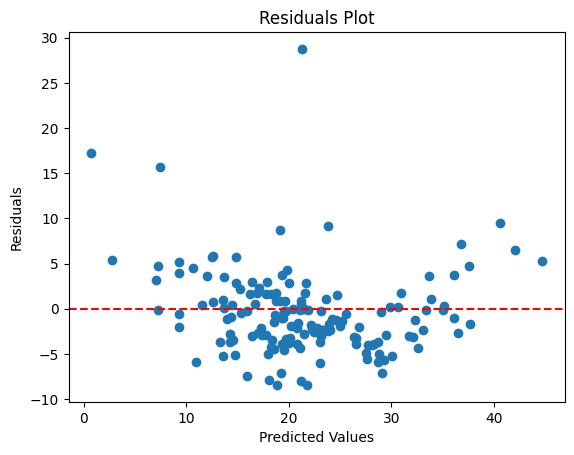

The spread of residuals appears mostly random around the zero line, which is good as it indicates there are 
no obvious patterns of errors. However, there are a few points with high residuals. This could mean that there are 
some outliers or specific situations where the model does not perform well.


In [45]:
# 13. Perform further analysis for better interpretation of model results.

# Convert predictions to Pandas
predictions_pd = predictions.select("prediction", "medv").toPandas()

# Plot residuals
plt.scatter(predictions_pd['prediction'], predictions_pd['medv'] - predictions_pd['prediction'])
plt.title('Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()
print("The spread of residuals appears mostly random around the zero line, which is good as it indicates there are \nno obvious patterns of errors. However, there are a few points with high residuals. This could mean that there are \nsome outliers or specific situations where the model does not perform well.")

